In [17]:
# ================================================
# 1. Load Dependencies and Define Paths
# ================================================
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from tqdm import tqdm
import time

# Define paths
DATA_PATH = "../data/"
MODEL_PATH = "../models/saved/"
os.makedirs(MODEL_PATH, exist_ok=True)

In [18]:
# ================================================
# 2. Load CSV Files
# ================================================
players = pd.read_csv(DATA_PATH + "players.csv")
transfers = pd.read_csv(DATA_PATH + "transfers.csv")
player_valuations = pd.read_csv(DATA_PATH + "player_valuations.csv")
appearances = pd.read_csv(DATA_PATH + "appearances.csv")
clubs = pd.read_csv(DATA_PATH + "clubs.csv")
competitions = pd.read_csv(DATA_PATH + "competitions.csv")
games = pd.read_csv(DATA_PATH + "games.csv")

In [19]:
# ================================================
# 3. Prepare Player Features
# ================================================
player_info = players[['player_id', 'name', 'date_of_birth', 'position', 'country_of_citizenship']]
latest_value = player_valuations.sort_values('date').drop_duplicates('player_id', keep='last')
player_info = player_info.merge(latest_value[['player_id', 'market_value_in_eur']], on='player_id', how='left')

player_info['date_of_birth'] = pd.to_datetime(player_info['date_of_birth'], errors='coerce')
player_info['age'] = 2025 - player_info['date_of_birth'].dt.year

appearances.rename(columns={"minutes_played;;;;;;;;": "minutes_played"}, inplace=True)
appearances['minutes_played'] = appearances['minutes_played'].astype(str).str.replace(';', '', regex=False)
appearances['minutes_played'] = pd.to_numeric(appearances['minutes_played'], errors='coerce')

performance = appearances.groupby('player_id').agg({
    'goals': 'mean',
    'assists': 'mean',
    'minutes_played': 'mean'
}).reset_index()

player_info = player_info.merge(performance, on='player_id', how='left')
player_info = player_info.dropna(subset=['age'])
player_info.loc[:, ['market_value_in_eur', 'goals', 'assists', 'minutes_played']] = (
    player_info.loc[:, ['market_value_in_eur', 'goals', 'assists', 'minutes_played']].fillna(0)
)

player_info['worthiness'] = (
    player_info['goals'] * 4 + player_info['assists'] * 3 + player_info['minutes_played'] / 90
)

player_info['valuable_player'] = (
    player_info['market_value_in_eur'] > player_info['market_value_in_eur'].quantile(0.75)
).astype(int)

In [32]:
# ================================================
# 4. Prepare Club Features
# ================================================
# Recupera o country_name da liga do clube (domestic_competition_id)
clubs = clubs.merge(
    competitions[['competition_id', 'country_name']],
    left_on='domestic_competition_id',
    right_on='competition_id',
    how='left',
    suffixes=(None, '_comp')
)

club_info = clubs[['club_id', 'name', 'country_name', 'squad_size', 'average_age', 'foreigners_number', 
                   'foreigners_percentage', 'national_team_players']].copy()

club_info['foreigners_percentage'] = club_info['foreigners_percentage'].astype(str).str.replace('%', '', regex=False).astype(float).fillna(0)

if 'club_id' not in player_info.columns:
    latest_transfers = transfers.sort_values('transfer_date', ascending=False).drop_duplicates('player_id')
    player_info = player_info.merge(latest_transfers[['player_id', 'from_club_id']], on='player_id', how='left')
    player_info.rename(columns={'from_club_id': 'club_id'}, inplace=True)

keywords_to_exclude = ['-20', 'dissolved', 'retired', 'defunct', 'inactive']
club_info = club_info[~club_info['name'].str.lower().str.contains('|'.join(keywords_to_exclude))]

player_values = player_info[['player_id', 'club_id', 'position', 'market_value_in_eur']].dropna()

avg_value = player_values.groupby('club_id')['market_value_in_eur'].mean().reset_index(name='average_player_value')
total_value = player_values.groupby('club_id')['market_value_in_eur'].sum().reset_index(name='total_market_value')
std_value = player_values.groupby('club_id')['market_value_in_eur'].std().reset_index(name='player_value_std')
max_by_position = player_values.groupby(['club_id', 'position'])['market_value_in_eur'].max().reset_index()
max_by_position = max_by_position.groupby('club_id')['market_value_in_eur'].max().reset_index(name='max_player_value_by_position')

club_info = club_info.merge(avg_value, on='club_id', how='left')
club_info = club_info.merge(total_value, on='club_id', how='left')
club_info = club_info.merge(total_value, on='club_id', how='left')
club_info = club_info.merge(std_value, on='club_id', how='left')
club_info = club_info.merge(max_by_position, on='club_id', how='left')

club_info['player_value_std'] = club_info['player_value_std'].fillna(1e-6)

In [33]:
# ================================================
# 5. Create Cleaned Training Dataset
# ================================================
training_rows = []
n_candidates = 3
valid_transfers = transfers[
    transfers['player_id'].isin(player_info['player_id']) &
    transfers['to_club_id'].isin(club_info['club_id'])
]

for _, row in tqdm(valid_transfers.iterrows(), total=valid_transfers.shape[0], desc="Building cleaned training set"):
    player_id = row['player_id']
    true_club_id = row['to_club_id']
    player = player_info[player_info['player_id'] == player_id].iloc[0]
    candidate_clubs = club_info[club_info['club_id'] != true_club_id].sample(n=min(n_candidates, len(club_info)-1), random_state=42)

    clubs_sample = pd.concat([
        club_info[club_info['club_id'] == true_club_id],
        candidate_clubs
    ])

    for _, club in clubs_sample.iterrows():
        label = 1 if club['club_id'] == true_club_id else 0
        avg_diff = player['market_value_in_eur'] - club['average_player_value']
        std_dev = club.get('player_value_std', 1e-6)
        row_data = {
            'player_id': player_id,
            'club_id': club['club_id'],
            'age': player['age'],
            'player_value': player['market_value_in_eur'],
            'goals': player['goals'],
            'assists': player['assists'],
            'minutes_played': player['minutes_played'],
            'position': player['position'],
            'nationality_match': int(player['country_of_citizenship'] == club['country_name']),
            'avg_player_value_diff': avg_diff,
            'above_club_max_position_value': int(player['market_value_in_eur'] > club['max_player_value_by_position']),
            'foreigners_percentage': club['foreigners_percentage'],
            'club_avg_player_value': club['average_player_value'],
            'club_national_team_players': club['national_team_players'],
            'player_value_zscore': (player['market_value_in_eur'] - club['average_player_value']) / (std_dev + 1e-6),
            'club_can_afford_realistically': int(player['market_value_in_eur'] <= club['average_player_value'] + 2 * std_dev),
            'same_league_or_country': int(player['country_of_citizenship'] == club['country_name']),
            'worthiness': player['worthiness'],
            'valuable_player': player['valuable_player'],
            'label': label
        }
        training_rows.append(row_data)

# Final training DataFrame
df_train = pd.DataFrame(training_rows)


Building cleaned training set: 100%|██████████| 36088/36088 [01:45<00:00, 342.37it/s]


C:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [21:02:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 288.62 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        34
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        25
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00        29
          15       1.00      1.00      1.00        25
          16       0.92      0.81      0.86        

C:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 1200x600 with 0 Axes>

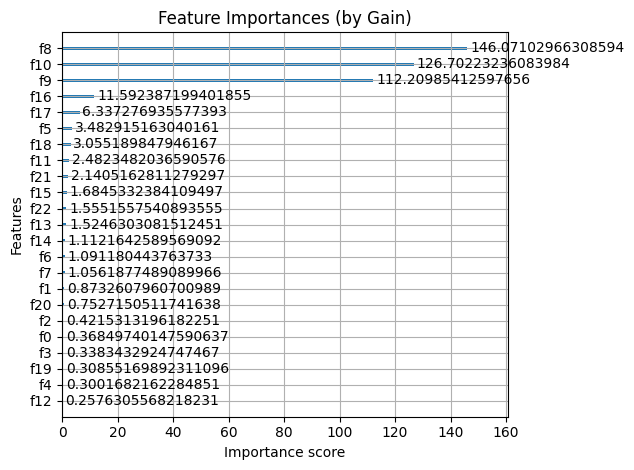

['../models/saved/xgb_label_encoder_clubs.pkl']

In [34]:
# ================================================
# 6. Train XGBoost Classifier (Improved version)
# ================================================
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
import joblib
import time
import matplotlib.pyplot as plt

# Add new features
features = df_train.copy()
features['value_ratio'] = features['player_value'] / (features['club_avg_player_value'] + 1e-6)
features['performance_sum'] = features['goals'] + features['assists']
features['performance_vs_value'] = features['performance_sum'] / (features['club_avg_player_value'] + 1e-6)
features['position_value_gap'] = features['player_value'] - features['club_avg_player_value'] * 1.5

# New: difference between player value and max paid by club
if 'max_player_value_by_position' not in features.columns:
    features = features.merge(club_info[['club_id', 'max_player_value_by_position']], on='club_id', how='left')

features['relative_to_max_paid'] = features['player_value'] / (features['max_player_value_by_position'] + 1e-6)
features['under_max_paid_flag'] = (features['player_value'] <= features['max_player_value_by_position'] * 1.5).astype(int)

# New: most common nationality per club
top_nationalities = player_info.groupby('club_id')['country_of_citizenship'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown').reset_index()
top_nationalities.columns = ['club_id', 'club_top_nationality']
features = features.merge(top_nationalities, on='club_id', how='left')
features['top_nationality_match'] = (player_info.set_index('player_id').loc[features['player_id']]['country_of_citizenship'].values == features['club_top_nationality']).astype(int)

valuation_change = player_valuations.groupby('player_id')['market_value_in_eur'].agg(['first', 'last']).reset_index()
valuation_change['valuation_trend'] = valuation_change['last'] - valuation_change['first']
features = features.merge(valuation_change[['player_id', 'valuation_trend']], on='player_id', how='left')
features['is_affordable'] = (features['player_value'] <= features['club_avg_player_value'] * 1.5).astype(int)
features['valuation_trend_scaled'] = features['valuation_trend'] / (features['player_value'] + 1e-6)
features = features.fillna(0)

# Filter classes with at least 5 samples
club_counts = features['club_id'].value_counts()
valid_clubs = club_counts[club_counts >= 5].index
features = features[features['club_id'].isin(valid_clubs)]

# Select features
feature_cols = [
    'age', 'player_value', 'goals', 'assists', 'minutes_played',
    'nationality_match', 'avg_player_value_diff', 'above_club_max_position_value',
    'foreigners_percentage', 'club_avg_player_value', 'club_national_team_players',
    'value_ratio', 'performance_vs_value', 'position_value_gap',
    'valuation_trend', 'is_affordable', 'player_value_zscore',
    'club_can_afford_realistically', 'same_league_or_country', 'valuation_trend_scaled',
    'relative_to_max_paid', 'under_max_paid_flag', 'top_nationality_match'
]

X = features[feature_cols]
y = features['club_id']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Manual XGBoost Hyperparameters
tuned_model = XGBClassifier(
    n_estimators=250,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    class_weight='balanced'
)

start = time.time()
tuned_model.fit(X_train_scaled, y_train)
print("Training time:", round(time.time() - start, 2), "seconds")

xgb_model = tuned_model

# Evaluate
y_pred = xgb_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=25)
plt.title("Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

# Save artifacts
joblib.dump(xgb_model, MODEL_PATH + "xgb_transfer_model_clubs.pkl")
joblib.dump(scaler, MODEL_PATH + "xgb_scaler_clubs.pkl")
joblib.dump(label_encoder, MODEL_PATH + "xgb_label_encoder_clubs.pkl")



In [9]:
# ================================================
# 7. Recommend Clubs for Player using XGBoost
# ================================================
def recommend_clubs_xgb(player_data, club_info, model, scaler, label_encoder, top_k=5):
    rows = []
    for _, club in club_info.iterrows():
        avg_value = club['average_player_value'] + 1e-6
        valuation_trend = player_data.get('valuation_trend', 0)
        player_value = player_data['market_value_in_eur']

        row = {
            'age': player_data['age'],
            'player_value': player_value,
            'goals': player_data['goals'],
            'assists': player_data['assists'],
            'minutes_played': player_data['minutes_played'],
            'nationality_match': int(player_data['country_of_citizenship'] == club['country_name']),
            'avg_player_value_diff': player_value - club['average_player_value'],
            'above_club_max_position_value': int(player_value > club['max_player_value_by_position']),
            'foreigners_percentage': club['foreigners_percentage'],
            'club_avg_player_value': club['average_player_value'],
            'club_national_team_players': club['national_team_players'],
            'value_ratio': player_value / avg_value,
            'performance_vs_value': (player_data['goals'] + player_data['assists']) / avg_value,
            'position_value_gap': player_value - club['average_player_value'] * 1.5,
            'valuation_trend': valuation_trend,
            'is_affordable': int(player_value <= club['average_player_value'] * 1.5),
            'player_value_zscore': (player_value - club['average_player_value']) / (club['player_value_std'] + 1e-6),
            'club_can_afford_realistically': int(player_value <= club['average_player_value'] + 2 * club['player_value_std']),
            'same_league_or_country': int(player_data['country_of_citizenship'] == club['country_name'] or player_data.get('league_name', '') == club.get('league_name', '')),
            'valuation_trend_scaled': valuation_trend / (player_value + 1e-6),
            'relative_to_max_paid': player_value / (club['max_player_value_by_position'] + 1e-6),
            'under_max_paid_flag': int(player_value <= club['max_player_value_by_position'] * 1.5),
            'top_nationality_match': int(player_data['country_of_citizenship'] == club.get('club_top_nationality', '')),
            'club_id': club['club_id'],
            'club_name': club['name']
        }
        try:
            row['encoded_label'] = label_encoder.transform([club['club_id']])[0]
            rows.append(row)
        except ValueError:
            continue

    df = pd.DataFrame(rows)
    X = df[feature_cols].fillna(0)
    X_scaled = scaler.transform(X)
    probs = model.predict_proba(X_scaled)

    # Apply penalty to unrealistic club suggestions
    penalty_mask = df['under_max_paid_flag'] == 0
    df['probability'] = [probs[i, lbl] * (0.2 if penalty_mask.iloc[i] else 1.0) for i, lbl in enumerate(df['encoded_label'])]

    top_indices = np.argsort(df['probability'])[::-1][:top_k]
    return df.iloc[top_indices][['club_name', 'probability']]


In [10]:
recommend_clubs_xgb(player_id=346766, top_k=10)


TypeError: recommend_clubs_xgb() got an unexpected keyword argument 'player_id'

In [132]:
print("Clubes com total_market_value faltando:", club_info['total_market_value'].isna().sum())


Clubes com total_market_value faltando: 30


In [129]:
club_info.loc[club_info['name'].str.contains('FC Penafiel')]


,club_id,name,country_name,total_market_value_x,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,average_player_value_x,player_value_std_x,player_value_std_y,average_player_value_y,total_market_value_y,average_player_value,total_market_value,player_value_std,max_player_value_by_position
75,3327,FC Penafiel,Portugal,NaN,28,27.9,4,14.3,0,0.0,NaN,NaN,200000.0,200000.0,200000.0,200000.0,0.000001,200000.0
